# Grid Search
Esse notebook contém um código expereimental que busca encontrar a estrutura de rede neural mais adequada para equalizar sinais em transmissões ópticas de 12 km

In [4]:
import numpy as np
from optic.torchUtils import slidingWindowDataSet, MLP
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from optic.comm.modulation import GrayMapping, modulateGray, demodulateGray
from optic.dsp.core import pulseShape, lowPassFIR, pnorm, signal_power
from optic.utils import parameters, dBm2W
from optic.models.devices import mzm, photodiode, edfa
from optic.comm.modulation import GrayMapping, modulateGray, demodulateGray

from tqdm.notebook import tqdm
from commpy.utilities  import upsample
from optic.dsp.core import firFilter
from optic.models.channels import linearFiberChannel
import matplotlib.pyplot as plt
import scienceplots

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [5]:
import OpticFunctions as of
import importlib
import IPython.display as ipd

In [6]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize

figsize(10, 6)
plt.rcParams.update({'font.size': 11})

In [7]:
# %load_ext autoreload
# %autoreload 2

In [8]:
np.random.seed(seed=123)
#plt.style.use(['science','ieee'])

In [9]:
grid_folder = "Modelos_Grid_Search"
if not os.path.exists(grid_folder):
    os.mkdir(grid_folder)

In [10]:
# Parâmetros para geração de sinal
SpS = 16
Rs = 40e9
M = 8
num_symbs = 5e3
dist_fibra = 3

In [11]:
sinaltx, symbtx = of.SimulaSinalOptico(SpS = SpS, Rs = Rs, M = M, num_symbs = num_symbs)

SymbTx antes da normalização:  [-1. -7. -3. ...  7. -3. -5.]


In [12]:
sinalrx = of.SimulaCanalOptico(sinal = sinaltx, SpS = SpS, Rs = Rs, dist_fibra = dist_fibra)

Number of counted errors = 640 
BER = 4.32e-02 


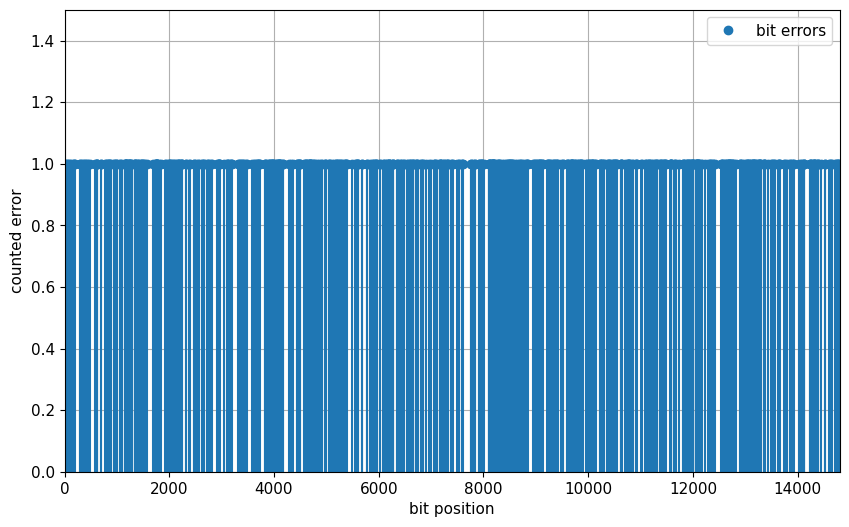

In [13]:
bits_tx = of.RecuperaBits(sinaltx, SpS, M)
bits_rx = of.RecuperaBits(sinalrx, SpS, M)
of.CalculaBER(bits_tx, bits_rx)

In [32]:
Ntaps = 2
batch_size = 100
shuffle = True
shuffle_full = False

train_dataset, test_dataset, full_dataset = of.CriaDataSet(symbtx, sinalrx, SpS, Ntaps = Ntaps)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)
full_dataloader = DataLoader(full_dataset, batch_size=len(full_dataset), shuffle=shuffle_full)

In [33]:
loss_fn = nn.MSELoss()
epochs = 110
cada_print = 50

# Teste das redes Neurais

In [34]:
def test_learning(progress_dataloader, equalizer, loss, loss_list):
    size = len(progress_dataloader.dataset)
    num_batches = len(progress_dataloader)
    equalizer.eval()
    eval_loss = 0
    with torch.no_grad():
        for x, y in progress_dataloader:
            x, y = x.float(), y.float()
            pred = equalizer(x)
            eval_loss += loss(pred, y).item()
    eval_loss /= num_batches
    loss_list.append(eval_loss)
    return loss_list

In [35]:
def training(train_dataloader, equalizer, loss, optimizer, cada_print):
    size = len(train_dataloader.dataset)
    
    equalizer.train()
    for batch, (x, y) in enumerate(train_dataloader):
        x, y = x.float(), y.float()
        predict = equalizer(x)
        loss_value = loss(predict, y)
        
        loss_value.backward()
        optimizer.step()
        optimizer.zero_grad()            

In [36]:
loss_fn = nn.MSELoss()
epochs = 110
cada_print = 500

loss_list = []
perda_media = []
estrutura = []

for i in range(1, 7):
    for y in range(1, 7):
        modelo = MLP([2, y, i, 1])
        optimizer = torch.optim.Adam(modelo.parameters(), lr = 0.0005)
        numero = int(str(y)+str(i))
        estrutura.append(numero)
        
        print(f"Modelo{numero}\n-------------------------------")
        for t in range(epochs):
            training(train_dataloader, modelo, loss_fn, optimizer, cada_print)
            perda_individual = test_learning(test_dataloader, modelo, loss_fn, loss_list)
        
        print(f"Perda média: {perda_individual[-1]}\n")
        perda_media.append(perda_individual[-1])
        caminho = os.path.join(grid_folder, f"Modelo{numero}.pth")
        torch.save(modelo, caminho)

Modelo11
-------------------------------
Perda média: 0.03887679111212492

Modelo21
-------------------------------
Perda média: 0.015274723153561353

Modelo31
-------------------------------
Perda média: 0.015919146407395602

Modelo41
-------------------------------
Perda média: 0.015767939668148757

Modelo51
-------------------------------
Perda média: 0.9981734573841095

Modelo61
-------------------------------
Perda média: 0.016526054963469504

Modelo12
-------------------------------
Perda média: 0.04152489863336086

Modelo22
-------------------------------
Perda média: 0.0154246405698359

Modelo32
-------------------------------
Perda média: 0.017512463498860598

Modelo42
-------------------------------
Perda média: 0.015930260811001063

Modelo52
-------------------------------
Perda média: 0.013749910704791545

Modelo62
-------------------------------
Perda média: 0.015903036575764418

Modelo13
-------------------------------
Perda média: 0.01361518083140254

Modelo23
----------

In [37]:
import pandas as pd

df = pd.DataFrame([perda_media[i:i+6] for i in range(0, len(perda_media), 6)],
                  index=range(1, 7), columns=range(1, 7))

dfe = pd.DataFrame([estrutura[i:i+6] for i in range(0, len(estrutura), 6)],
                  index=range(1, 7), columns=range(1, 7))

maior_valor = df.values.max()
menor_valor = df.values.min()

def highlight_max_min(val):
    color = ''
    if val == maior_valor:
        color = 'red'
    elif val == menor_valor:
        color = 'blue'
    return f'color: {color}'

styled_df = df.style.applymap(highlight_max_min)

styled_df

,1,2,3,4,5,6
1,0.038877,0.015275,0.015919,0.015768,0.998173,0.016526
2,0.041525,0.015425,0.017512,0.015930,0.013750,0.015903
3,0.013615,0.014658,0.014967,0.018486,0.044641,0.013436
4,0.014515,0.014484,0.014489,0.013884,0.016619,0.013526
5,0.014797,0.014419,0.014684,0.014974,0.013835,0.032470
6,0.014196,0.014355,0.013025,0.013683,0.012713,0.012973


In [38]:
#dfe

In [39]:
plt.style.use('science')
plt.rcParams['text.usetex'] = False
plt.rcParams['font.family'] = 'Arial'

In [40]:
const = GrayMapping(M, 'pam') 
Es = signal_power(const)

In [44]:

discard = 100
power = np.arange(-15, 0)
BER4 = np.zeros(power.size)
BERNN = [[[0 for _ in range(len(power))] for _ in range(6)] for _ in range(6)]

SpS_out = 1
Ntaps = 2

for ind, Pin in enumerate(power):
    sinaltx4, symbtx4 = of.SimulaSinalOptico(SpS=SpS, Rs=Rs, M=M, Pi_dBm=Pin, num_symbs=2e4)
    
    irx4 = of.SimulaCanalOptico(sinaltx4, SpS=SpS, Rs=Rs, dist_fibra=6)
    
    bitsTx4 = of.RecuperaBits(sinaltx4, SpS, M)
    bitsRx4 = of.RecuperaBits(irx4, SpS, M)
    
    err = np.logical_xor(bitsRx4[discard:bitsRx4.size-discard], bitsTx4[discard:bitsTx4.size-discard])
    BER4[ind] = np.mean(err)
    
    signalrx4 = pnorm(irx4[0::SpS//SpS_out])
    signalrx4= (signalrx4 - np.mean(signalrx4))/np.std(signalrx4)
    
    dataset4 = slidingWindowDataSet(signalrx4, symbtx4, Ntaps, SpS_out)
    
    dataloader4 = DataLoader(dataset4, batch_size=len(dataset4), shuffle=False)
    
    for x in range(2, 7):
        for y in range(3, 7):
            numero = int(str(x)+str(y))
            caminho = os.path.join(grid_folder, f"Modelo{numero}.pth")
            modelo = torch.load(caminho)
            symbNN = of.GeraSinalEqualizado(modelo, dataloader4)
            bitsRxNN = demodulateGray(np.sqrt(Es) * pnorm(symbNN), M, 'pam')
            err = np.logical_xor(bitsRxNN[discard:bitsRxNN.size-discard], bitsTx4[discard:bitsTx4.size-discard])
            BERNN[x-2][y-3][ind] = np.mean(err)
            indice = int(str(x-2)+str(y-3)+str(ind))
            print(f"indice: {indice}")
            print(f'BER = {BERNN[x-2][y-3][ind]:.2e}')

SymbTx antes da normalização:  [-5.  3.  7. ...  5.  5.  3.]
indice: 0
BER = 2.41e-01
indice: 10
BER = 2.42e-01
indice: 20
BER = 2.42e-01
indice: 30
BER = 2.43e-01
indice: 100
BER = 2.43e-01
indice: 110
BER = 2.41e-01
indice: 120
BER = 2.41e-01
indice: 130
BER = 2.43e-01
indice: 200
BER = 2.41e-01
indice: 210
BER = 2.39e-01
indice: 220
BER = 2.42e-01
indice: 230
BER = 2.37e-01
indice: 300
BER = 2.04e-01
indice: 310
BER = 2.43e-01
indice: 320
BER = 2.40e-01
indice: 330
BER = 2.41e-01
indice: 400
BER = 2.43e-01
indice: 410
BER = 2.40e-01
indice: 420
BER = 2.02e-01
indice: 430
BER = 2.43e-01
SymbTx antes da normalização:  [ 7. -7.  7. ... -5.  3.  3.]
indice: 1
BER = 2.06e-01
indice: 11
BER = 2.07e-01
indice: 21
BER = 2.07e-01
indice: 31
BER = 2.08e-01
indice: 101
BER = 2.09e-01
indice: 111
BER = 2.06e-01
indice: 121
BER = 2.06e-01
indice: 131
BER = 2.08e-01
indice: 201
BER = 2.07e-01
indice: 211
BER = 2.04e-01
indice: 221
BER = 2.08e-01
indice: 231
BER = 2.02e-01
indice: 301
BER = 1.70e-

indice: 3013
BER = 4.60e-02
indice: 3113
BER = 6.93e-02
indice: 3213
BER = 6.21e-02
indice: 3313
BER = 6.23e-02
indice: 4013
BER = 6.38e-02
indice: 4113
BER = 6.44e-02
indice: 4213
BER = 3.62e-02
indice: 4313
BER = 6.39e-02
SymbTx antes da normalização:  [ 5. -5. -3. ... -3. -1. -7.]
indice: 14
BER = 6.37e-02
indice: 114
BER = 6.35e-02
indice: 214
BER = 6.32e-02
indice: 314
BER = 6.33e-02
indice: 1014
BER = 6.53e-02
indice: 1114
BER = 6.08e-02
indice: 1214
BER = 6.33e-02
indice: 1314
BER = 6.21e-02
indice: 2014
BER = 6.66e-02
indice: 2114
BER = 6.22e-02
indice: 2214
BER = 6.46e-02
indice: 2314
BER = 6.06e-02
indice: 3014
BER = 4.27e-02
indice: 3114
BER = 6.76e-02
indice: 3214
BER = 6.17e-02
indice: 3314
BER = 6.16e-02
indice: 4014
BER = 6.22e-02
indice: 4114
BER = 6.35e-02
indice: 4214
BER = 3.33e-02
indice: 4314
BER = 6.33e-02


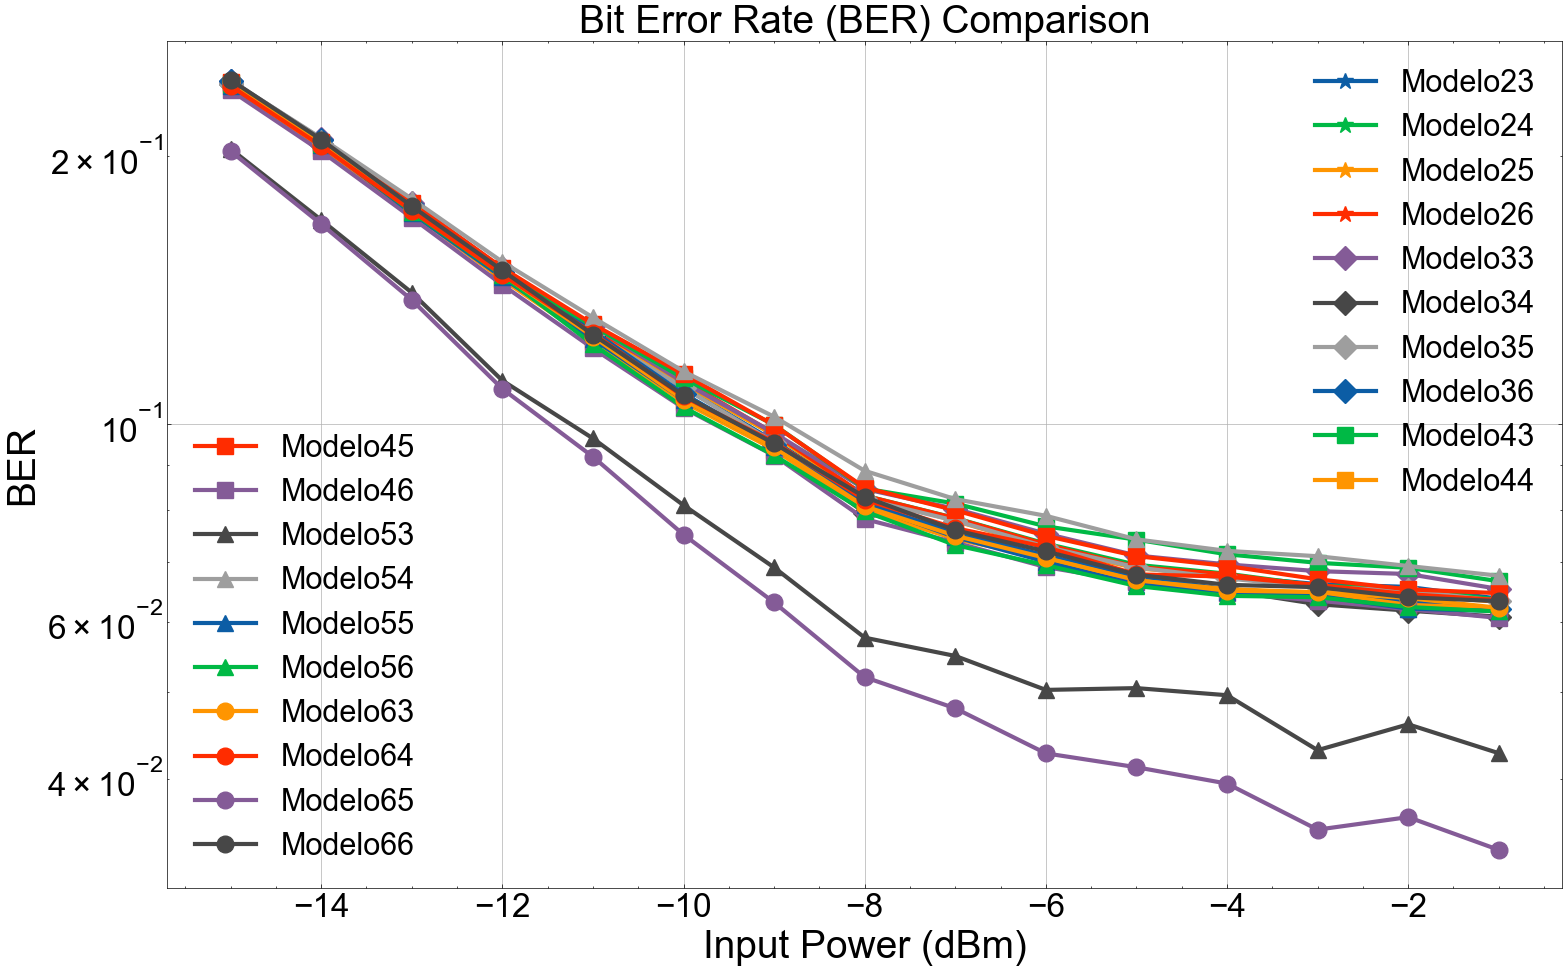

In [45]:
marcador = ['*', 'D', 's', '^', 'o']
plt.figure(figsize=(18, 11))

# Plota as curvas
for x in range(2, 7):
    for y in range(3, 7):
        numero = (str(x)+str(y))
        plt.semilogy(power, BERNN[x-2][y-3], 
                     label=f'Modelo{numero}', 
                     linewidth=3, 
                     marker=marcador[x-2], 
                     markersize = 12)

plt.xlabel('Input Power (dBm)', fontsize = 28)
plt.ylabel('BER', fontsize = 28)
plt.title('Bit Error Rate (BER) Comparison', fontsize = 28)
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24

plt.grid(True)

# Cria a primeira legenda
handles, labels = plt.gca().get_legend_handles_labels()
legend1 = plt.legend(handles[:10], labels[:10], loc='upper right', fontsize=22)

# Adiciona a primeira legenda ao gráfico
plt.gca().add_artist(legend1)

# Cria a segunda legenda
plt.legend(handles[10:], labels[10:], loc='lower left', fontsize=22)

plt.show()